In [5]:
## Collect initial time
import time
start_time = time.time()
print ('Training start')

## Necessary imports
import numpy as np
import pandas as pd
import xgboost as xg
import pickle
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

## Load trainning database
import os
path = "..."
os.chdir(path)
df = pd.read_csv("Data_Train\U_A_Train_All.csv")

# Training and validation data split
df_train, df_validation = train_test_split(df, test_size=0.30, shuffle=True)

X_train = df_train[["Uwall", "Uroof", "Uwind", "g_glass","Q_int","Tsp","ACH","SSEcrgd", "Rc", "HDD_crgd"]]
y_train = df_train['Dem_crgd']

X_validation = df_validation[["Uwall", "Uroof", "Uwind", "g_glass","Q_int","Tsp","ACH","SSEcrgd", "Rc", "HDD_crgd"]]
y_validation = df_validation['Dem_crgd']

# Train and test set are converted to DMatrix objects, as it is required by learning API.
train_dmatrix = xg.DMatrix(X_train, y_train)
validation_dmatrix = xg.DMatrix(X_validation, y_validation)

## XGBoost model development
# Define hyperparameter
params = { 'max_depth': [3, 6, 10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 200, 500],
           'colsample_bytree': [0.3, 0.5, 0.7]}
  
xgbr = xg.XGBRegressor(seed = 20)
optimizer = GridSearchCV(estimator=xgbr,
                         param_grid=params,
                         scoring='neg_root_mean_squared_error',
                         verbose=1)
optimizer.fit(X_train, y_train)    

# Export trainned model
pickle.dump(optimizer, open('model_All-HDD_Demand.pkl', 'wb'))

# Validate trainned model
pred = optimizer.predict(X_validation)

## Error Computation
rmse = np.sqrt(MSE(y_validation, pred))
mae = mean_absolute_error(y_validation, pred)
mape = mean_absolute_percentage_error(y_validation, pred)
print(f'MAE = {mae}')
print(f'MAPE = {mape}')
print(f'RMSE = {rmse}')

## Calculate total computation time (sourcing to error computing)
end_time = time.time()
duration = end_time - start_time
print ('Training duration: ', np.divide(duration, 60), 'minutes')



Training start
Fitting 5 folds for each of 81 candidates, totalling 405 fits
MAE = 9974229.667241393
MAPE = 0.3705119860365734
RMSE = 16738315.8059022
Training duration:  3.98783122698466 minutes


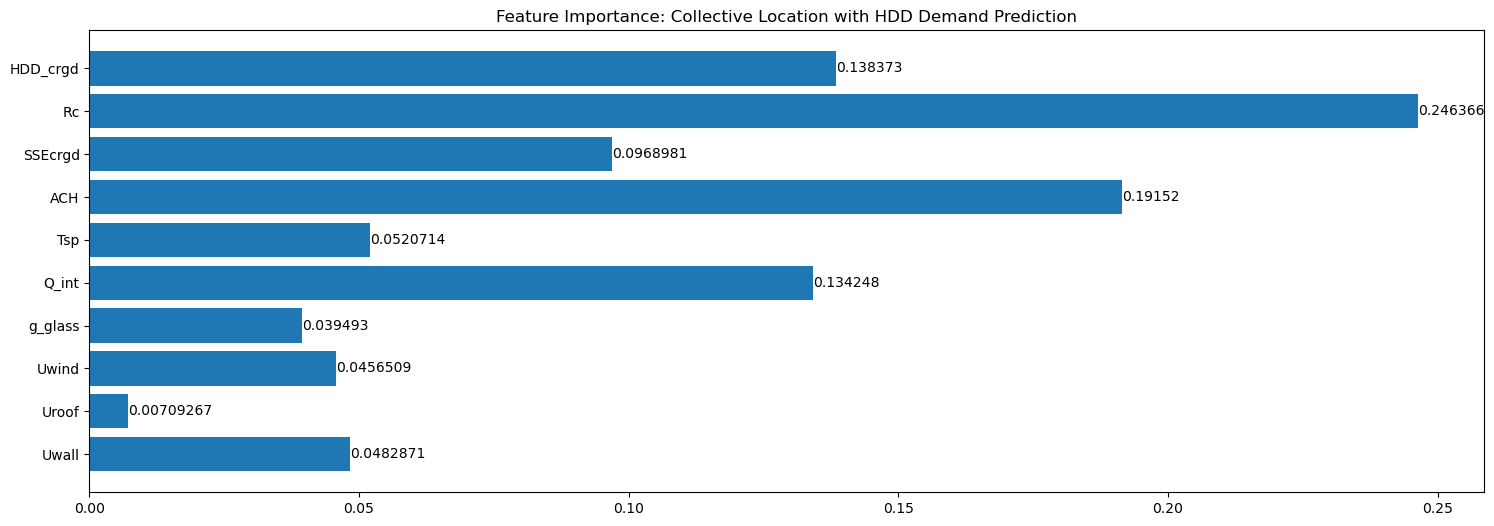

Feature importance figure is saved


In [6]:
## Feature Importance
import matplotlib.pyplot as plt

# Collect features and feature importance
Importance = optimizer.best_estimator_.feature_importances_
Feature = ["Uwall", "Uroof", "Uwind", "g_glass","Q_int","Tsp","ACH","SSEcrgd", "Rc", "HDD_crgd"]

# Generate plot
fig, ax = plt.subplots(figsize =(18,6))
hbar = plt.barh (Feature, Importance)
ax.bar_label(hbar)
plt.title("Feature Importance: Collective Location with HDD Demand Prediction")
plt.show()

# Export graph
fig.savefig(r'Result\FeatureImportance_All-HDD_Demand.png', format="png", dpi=800)
print ('Feature importance figure is saved')


In [7]:
## Unit error calculation section (error unit: Wh/m2)

# Check any duplicate value of the heating demand in the initial dataset
# Count the number of heating demand values
df2 = df.pivot_table(index = ['Dem_crgd'], aggfunc ='size')
if len(df) == len(df2) :
    print("No duplicates found, unit demand calculation is safe")
else:
    print("Demand duplicated found, run separate unit demand calculation!!")
    ValCases = pd.DataFrame(df_validation)
    ValCases['Prediction'] = np.array(pred) 
    ValCases.to_csv(r'All-HDD_Demand_validationCases.csv')
    print ("Validation Cases and Prediction are exported")
    #df2.to_csv(r'Dupilcates.csv')

# Generate separate DB for all validation cases
val_demand = y_validation
val_DB = pd.merge(val_demand, df, on ='Dem_crgd', how ='left')

# Separate building case to building shape code 
Bld_case = val_DB['Casos']
Bld_shape = Bld_case.str.split(".", expand = True)
Bld_shape.columns = ["Case", "Shape", "LocCode"]

# Vlookup the heated floor area   
Shape_code = pd.read_csv("Data_Train\Details_BuildingShape.csv")
Area_lookup = pd.merge(Bld_shape, Shape_code, on ='Shape', how ='left')

# Append HFArea, real and predicted demand  (unit: Wh)
# Initial row sequence from y_validation is maintained
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    dframe = pd.DataFrame(Area_lookup)
    dframe['RealDemand'] = list(y_validation)
    dframe['Prediction'] = list(pred)

# Define the necessary array (HeatedFloorArea, RealDemadnd, PredictedDemand)
HFA = np.array(Area_lookup['HFArea'])
RealDemand = np.array(y_validation)
PredDemand = np.array(pred) 

# Calculate the unit demand  (unit: Wh/m2)
URDemand = np.divide(RealDemand, HFA)
UPDemand = np.divide(PredDemand, HFA)

# Merge unit demand values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    dframe1 = pd.DataFrame(Area_lookup)
    dframe1['RealDemand'] = URDemand
    dframe1['Prediction'] = UPDemand
    # print(dframe1)
    #dframe1.to_csv(r'dframe1.csv')

# Append all values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    dframe = pd.DataFrame(Area_lookup)
    # Cumulative values and error (kWh)
    dframe['Actual (kWh)'] = np.divide(y_validation,1000)
    dframe['Prediction (kWh)'] = np.divide(pred,1000)
    Error = np.subtract(RealDemand, PredDemand)
    dframe['Error (kWh)'] = np.divide(Error,1000)
    # Unit values and error (kWh/m2)
    dframe['Actual (kWh/m2)'] = np.divide(URDemand,1000)
    dframe['Prediction (kWh/m2)'] = np.divide(UPDemand,1000)
    UError = np.subtract(URDemand, UPDemand)
    dframe['Error (kWh/m2)'] = np.divide(UError,1000)
    #print (dframe)
    
# Error calculation for unit heating demand
urmse = np.sqrt(MSE(URDemand, UPDemand))
umae = mean_absolute_error(URDemand, UPDemand)
umape = mean_absolute_percentage_error(URDemand, UPDemand)
print(f'Unit MAE = {umae}')
print(f'Unit MAPE = {umape}')
print(f'Unit RMSE = {urmse}')

No duplicates found, unit demand calculation is safe
Unit MAE = 6462.5477767600705
Unit MAPE = 0.3705119860365734
Unit RMSE = 9180.94325003005


In [8]:
## Export real, prediction and direct error (Unit: Wh)
# Calculate direct error (real - prediction)
Error = np.subtract(RealDemand, PredDemand)
dframe['Actual (kWh)'] = np.divide(RealDemand,1000)
dframe['Prediction (kWh)'] = np.divide(PredDemand,1000)
dframe['Error (kWh)'] = np.divide(Error,1000)
result = dframe[["Case","Shape","HFArea","Actual (kWh)","Prediction (kWh)", "Error (kWh)" ]]
result.to_csv(r'Result\All-HDD_demand_train_Result.csv')
print ('Prediction result is exported')


## Export real, prediction and direct error per area (Unit: Wh/m2)
# Calculate direct error (real - prediction)
UError = np.subtract(URDemand, UPDemand)
dframe1['Actual (kWh/m2)'] = np.divide(URDemand,1000)
dframe1['Prediction (kWh/m2)'] = np.divide(UPDemand,1000)
dframe1['Error (kWh/m2)'] = np.divide(UError,1000)
Uresult = dframe1[["Case","Shape","HFArea", "Actual (kWh/m2)","Prediction (kWh/m2)", "Error (kWh/m2)" ]]
Uresult.to_csv(r'Result\All-HDD_demand_train_UResult.csv')
print ('Unit prediction result is exported')

Prediction result is exported
Unit prediction result is exported


max y=  662642.5625
min y=  -25316.3828125
max x=  690873.7831
min x=  736.23
Regression line m and b:  0.9274052374125695 and 6392.510854391476
Prediction graph is saved


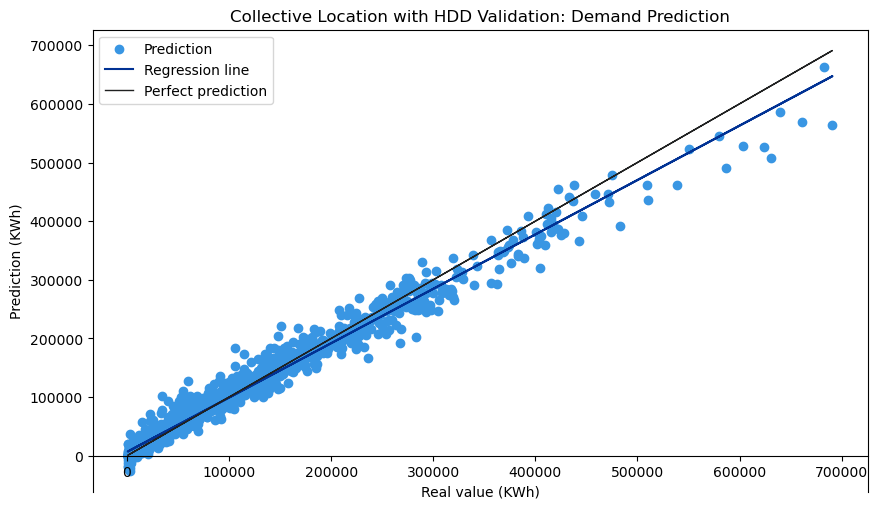

In [9]:
## Plot: real and predicted values  (unit: kWh)
import matplotlib.pyplot as plt

# Define source, x and y data
source = result
x1 = source['Actual (kWh)']
y1 = source['Prediction (kWh)']

# Data check
print('max y= ', y1.max())
print('min y= ', y1.min())
print('max x= ', x1.max())
print('min x= ', x1.min())

# Set graph size
fig = plt.figure(figsize =(10,6))

# Adjust x-axis to be at y=0
ax = fig.add_subplot(1, 1, 1)
ax.spines['bottom'].set_position('zero')

# Plot the data
plt.scatter(x1, y1, c='#3996e3', label='Prediction')

# Set axis label and title
plt.xlabel("Real value (KWh)")
plt.ylabel("Prediction (KWh)")
plt.title("Collective Location with HDD Validation: Demand Prediction")

# Create regression line
m, b = np.polyfit(x1, y1, 1)
plt.plot(x1, m*x1+b , c='#013294', lw=1.5, label='Regression line')
print ('Regression line m and b: ', m,'and', b)

# Create perfect prediction line (m=1)
plt.plot(x1, x1 , c='#202121', lw=1, label='Perfect prediction')

ax.legend()

# Export graph
plt.savefig(r'Result\All-HDD_demand_train_Prediction.png', format="png", dpi=800)
print ('Prediction graph is saved')


max y=  126670.26310000003
min y=  -77069.518
max x=  690873.7831
min x=  736.23
Error graph is saved


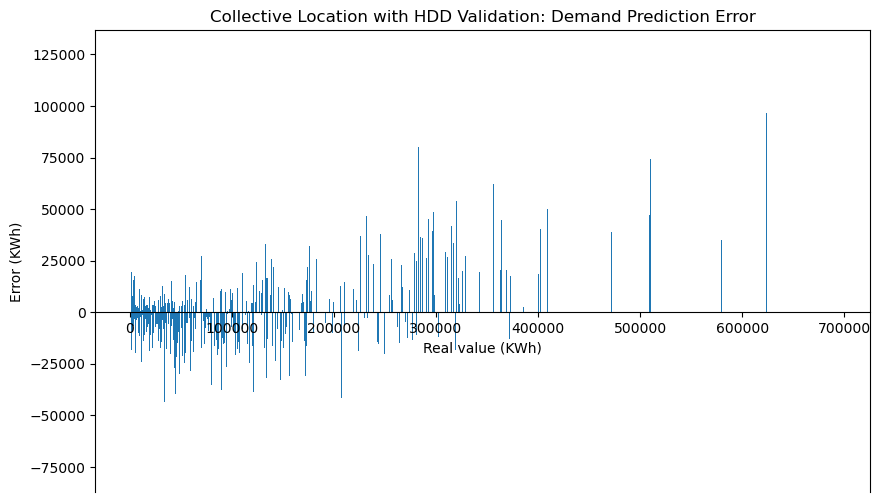

In [10]:
## Plot: prediction error and real value (unit: kWh)

# Define x and y data
# Error = real - prediction
x2 = source['Actual (kWh)']
y2 = source['Error (kWh)']

# Data check
print('max y= ', y2.max())
print('min y= ', y2.min())
print('max x= ', x2.max())
print('min x= ', x2.min())

# Set graph size
fig = plt.figure(figsize =(10,6))

# Adjust x-axis to be at y=0
ax = fig.add_subplot(1, 1, 1)
ax.spines['bottom'].set_position('zero')

# Plot the data
plt.bar(x2, y2, width=300)
#plt.xlim(0,610000)
#plt.ylim(-350000, 350000)

# Set axis label and title
plt.xlabel("Real value (KWh)")
plt.ylabel("Error (KWh)")
plt.title("Collective Location with HDD Validation: Demand Prediction Error")

# Export graph
plt.savefig(r'Result\All-HDD_demand_train_Error.png', format="png", dpi=800)
print ('Error graph is saved')

max y=  292.9227207333802
min y=  -23.715713138612866
max x=  274.6638131654264
min x=  0.205267251978844
Regression line m and b:  0.9727789635409918 and 2.323584480246541
Unit prediction graph is saved


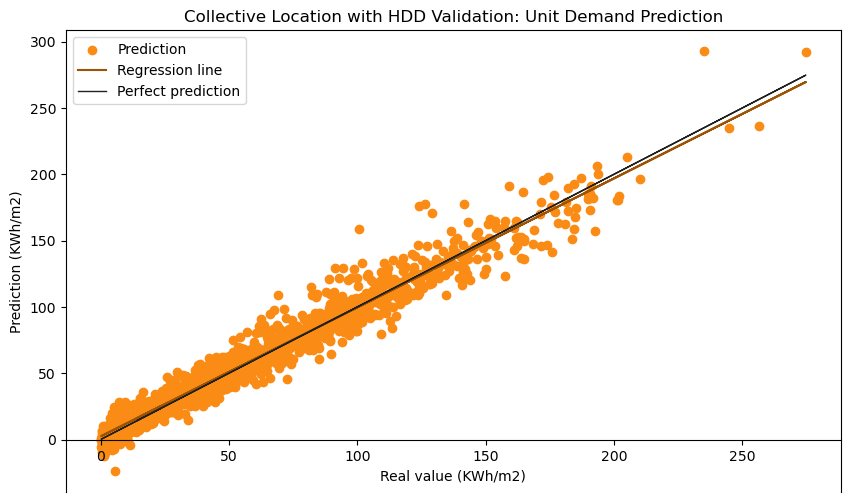

In [11]:
## Plot: unit real and predicted values  (unit: kWh/m2)

# Define source, x and y data
usource = Uresult
ux1 = usource['Actual (kWh/m2)']
uy1 = usource['Prediction (kWh/m2)']

# Data check
print('max y= ', uy1.max())
print('min y= ', uy1.min())
print('max x= ', ux1.max())
print('min x= ', ux1.min())

# Set graph size
fig = plt.figure(figsize =(10,6))

# Adjust x-axis to be at y=0
ax = fig.add_subplot(1, 1, 1)
ax.spines['bottom'].set_position('zero')

# Plot the data
plt.scatter(ux1, uy1, c='#fa8c16', label='Prediction')

# Set axis label and title
plt.xlabel("Real value (KWh/m2)")
plt.ylabel("Prediction (KWh/m2)")
plt.title("Collective Location with HDD Validation: Unit Demand Prediction")

# Create regression line
m, b = np.polyfit(ux1, uy1, 1)
plt.plot(ux1, m*ux1+b , c='#9e5302', lw=1.5, label='Regression line')
print ('Regression line m and b: ', m,'and', b)

# Create perfect prediction line (m=1)
plt.plot(ux1, ux1 , c='#202121', lw=1, label='Perfect prediction')

ax.legend()

# Export graph
plt.savefig(r'Result\All-HDD_demand_train_UPrediction.png', format="png", dpi=800)
print ('Unit prediction graph is saved')


max y=  35.316758097298646
min y=  -58.03742835156745
max x=  274.6638131654264
min x=  0.205267251978844
Unit error graph is saved


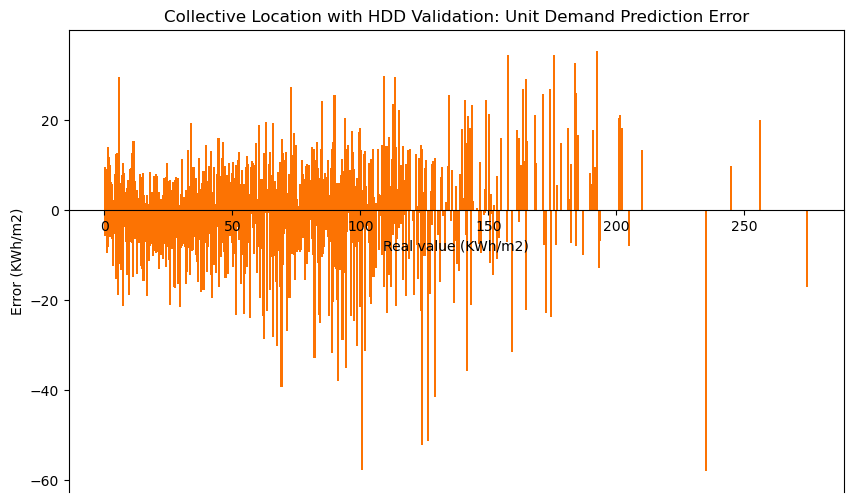

In [12]:
## Plot: unit prediction error and real value (unit: kWh)

# Define x and y data
# Error = real - prediction
ux2 = usource['Actual (kWh/m2)']
uy2 = usource['Error (kWh/m2)']

# Data check
print('max y= ', uy2.max())
print('min y= ', uy2.min())
print('max x= ', ux2.max())
print('min x= ', ux2.min())

# Set graph size
fig = plt.figure(figsize =(10,6))

# Adjust x-axis to be at y=0
ax = fig.add_subplot(1, 1, 1)
ax.spines['bottom'].set_position('zero')

# Plot the data
plt.bar(ux2, uy2, color='#fc7303')
#plt.xlim(0,610000)
#plt.ylim(-350000, 350000)

# Set axis label and title
plt.xlabel("Real value (KWh/m2)")
plt.ylabel("Error (KWh/m2)")
plt.title("Collective Location with HDD Validation: Unit Demand Prediction Error")

# Export graph
plt.savefig(r'Result\All-HDD_demand_train_UError.png', format="png", dpi=800)
print ('Unit error graph is saved')